In [113]:
from plotDecBoundaries import plotDecBoundaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [123]:
# OvR Method: breaks down the multi-class problem into multiple binary classification subproblems
#Load datasets
dataset4_train = pd.read_csv('dataset4_train.csv')
dataset5_train = pd.read_csv('dataset5_train.csv')
dataset6_train = pd.read_csv('dataset6_train.csv')
dataset4_test = pd.read_csv('dataset4_test.csv')
dataset5_test = pd.read_csv('dataset5_test.csv')
dataset6_test = pd.read_csv('dataset6_test.csv')

train_datasets = [dataset4_train, dataset5_train, dataset6_train]

train_mean_output = []

for dataset in train_datasets:
    find_classes = np.unique(dataset['Class'])  # Find the classes

    mean_vectors_output = []

    for classes in find_classes:
        copy_data = dataset.copy()
        copy_data['Class'] = np.where(copy_data['Class'] == classes, 1, 0)
        mean_vector = np.mean(copy_data[copy_data['Class'] == 1][['X-axis', 'Y-axis']].values, axis=0)
        mean_vectors_output.append((classes, mean_vector))

    train_mean_output.append(mean_vectors_output)
    
mean_arr_convert = []
#loop through each dataset in train_mean_output
for x in train_mean_output:
    #extract mean vectors and classes from the current dataset
    classes, mean_vectors = zip(*x) 
    mean_vectors_array = np.array(mean_vectors) #convert mean vectors to a NumPy array
    mean_arr_convert.append((classes, mean_vectors_array))

print("Mean Arr Convert:")
for mean_vectors in mean_arr_convert:
    print(mean_vectors)


#leaving points in indeterminate regions as unclassified
def ovr_classifier_unclassified(data, mean_vectors, confidence_threshold=0.0, unclassified_label=-1):
    confidences = []  

    for x, mean in mean_vectors:
        confidence_calc = np.dot(data, mean)
        confidences.append((x, confidence_calc))

    confidences.sort(key=lambda x: x[1], reverse=True)

    if confidences[0][1] - confidences[1][1] >= confidence_threshold:
        predicted_class_output = confidences[0][0]
    else:
        predicted_class_output = unclassified_label

    return predicted_class_output


# OvR classification function
# Function to predict the class of a data point using the OvR method
def ovr_classifier(data, mean_vectors):
    confidences = [] #store confidence score for each class 
    
    for x, mean in mean_vectors:
        confidence_calc = np.dot(data, mean)
        confidences.append((x, confidence_calc))
    predicted_class_output = max(confidences, key=lambda x: x[1])[0]

    return predicted_class_output



Mean Arr Convert:
((1.0, 2.0, 3.0), array([[ 1.18364448,  0.79225357],
       [-1.09023208, -1.00148188],
       [-1.85341506,  1.82366056]]))
((1.0, 2.0, 3.0), array([[ 0.80953245,  0.99867001],
       [-0.70501633, -0.91212312],
       [-1.91993599,  1.96192853]]))
((1.0, 2.0, 3.0), array([[ 1.58608409,  1.1710504 ],
       [ 0.04772534,  0.11132097],
       [-1.96284767,  1.98160218]]))


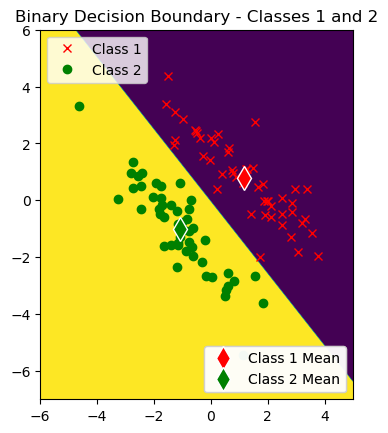

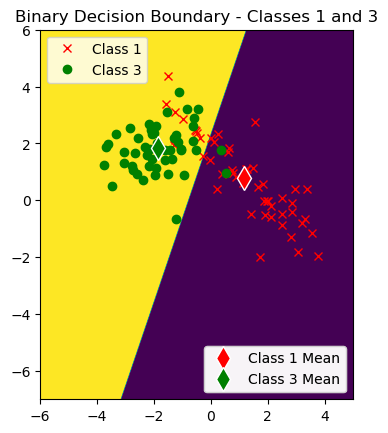

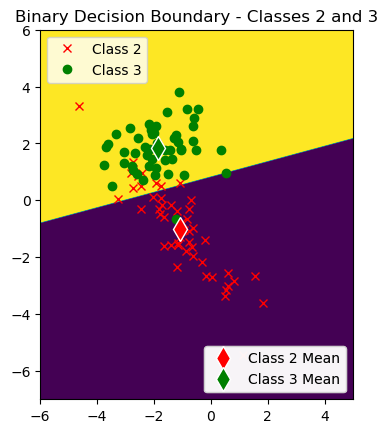

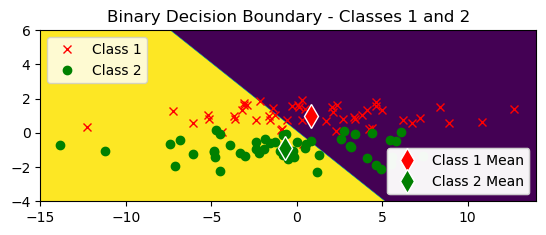

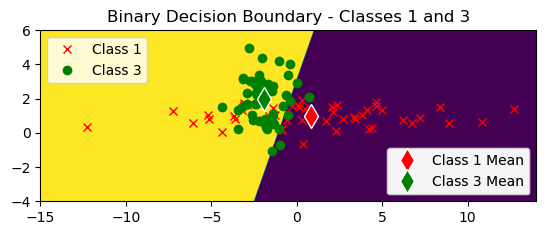

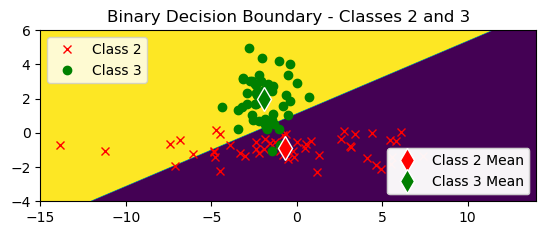

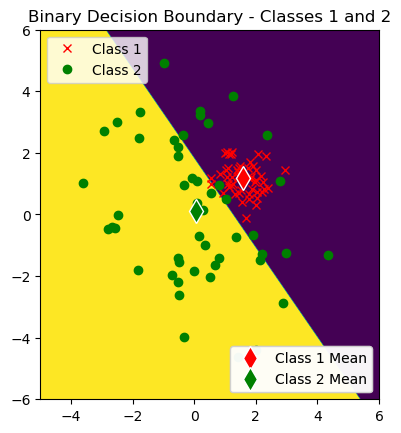

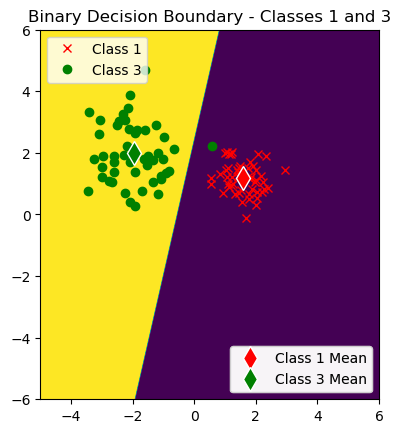

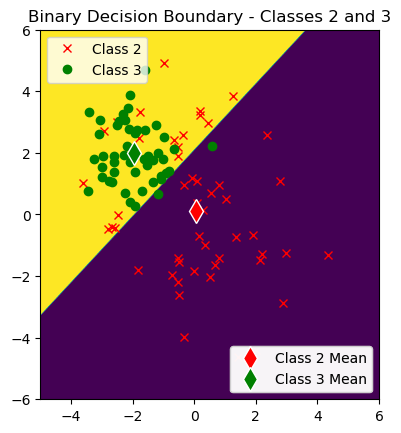

In [98]:
def plotBinaryDecisionBoundaries(training, label_train, sample_mean, class_pair):
    # Plot binary decision boundaries for each pair of classes
    indices = (label_train == class_pair[0]) | (label_train == class_pair[1])

    # Extract data for the selected classes
    binary_training = training[indices, :]
    binary_labels = label_train[indices]
    
    if set(class_pair) == {1, 2}:
        binary_means = sample_mean[:2]
    elif set(class_pair) == {1, 3}:
        binary_means = np.vstack((sample_mean[0], sample_mean[2]))
    elif set(class_pair) == {2, 3}:
        binary_means = sample_mean[1:]
    else:
        print("Invalid class_pair. Choose from (1, 2), (1, 3), or (2, 3).")
        return
    
    # Set the feature range for plotting
    max_x = np.ceil(max(training[:, 0])) + 1
    min_x = np.floor(min(training[:, 0])) - 1
    max_y = np.ceil(max(training[:, 1])) + 1
    min_y = np.floor(min(training[:, 1])) - 1

    xrange = (min_x, max_x)
    yrange = (min_y, max_y)

    # step size for how finely you want to visualize the decision boundary.
    inc = 0.005

    # generate grid coordinates. this will be the basis of the decision boundary visualization.
    (x, y) = np.meshgrid(np.arange(xrange[0], xrange[1]+inc/100, inc), np.arange(yrange[0], yrange[1]+inc/100, inc))

    # size of the (x, y) image, which will also be the size of the decision boundary image that is used as the plot background.
    image_size = x.shape
    xy = np.hstack((x.reshape(x.shape[0]*x.shape[1], 1, order='F'), y.reshape(y.shape[0]*y.shape[1], 1, order='F')))  # make (x,y) pairs as a bunch of row vectors.

    # distance measure evaluations for each (x,y) pair.
    dist_mat = cdist(xy, binary_means)
    pred_label = np.argmin(dist_mat, axis=1)

    # reshape the idx (which contains the class label) into an image.
    decisionmap = pred_label.reshape(image_size, order='F')

    # show the image, give each coordinate a color according to its class label
    plt.imshow(decisionmap, extent=[xrange[0], xrange[1], yrange[0], yrange[1]], origin='lower')

    # plot the class training data.
    plt.plot(training[label_train == class_pair[0], 0], training[label_train == class_pair[0], 1], 'rx')
    plt.plot(training[label_train == class_pair[1], 0], training[label_train == class_pair[1], 1], 'go')

    # include legend for training data
    l = plt.legend((f'Class {class_pair[0]}', f'Class {class_pair[1]}'), loc=2)
    plt.gca().add_artist(l)

    # plot the class mean vector.
    m1, = plt.plot(binary_means[0, 0], binary_means[0, 1], 'rd', markersize=12, markerfacecolor='r', markeredgecolor='w')
    m2, = plt.plot(binary_means[1, 0], binary_means[1, 1], 'gd', markersize=12, markerfacecolor='g', markeredgecolor='w')

    # include legend for class mean vector
    l1 = plt.legend([m1, m2], [f'Class {class_pair[0]} Mean', f'Class {class_pair[1]} Mean'], loc=4)
    plt.gca().add_artist(l1)

def plotDecBoundaries(training, label_train, sample_mean):
    for pair in [(1, 2), (1, 3), (2, 3)]:
        plotBinaryDecisionBoundaries(training, label_train, sample_mean, pair)
        plt.title(f"Binary Decision Boundary - Classes {pair[0]} and {pair[1]}")
        plt.show()
        
def plotFinalDecisionBoundary(training, label_train, sample_mean):
    # Plot the final decision boundary for the 3-class problem

    # Set the feature range for plotting
    max_x = np.ceil(max(training[:, 0])) + 1
    min_x = np.floor(min(training[:, 0])) - 1
    max_y = np.ceil(max(training[:, 1])) + 1
    min_y = np.floor(min(training[:, 1])) - 1

    xrange = (min_x, max_x)
    yrange = (min_y, max_y)

    inc = 0.005

    (x, y) = np.meshgrid(np.arange(xrange[0], xrange[1]+inc/100, inc), np.arange(yrange[0], yrange[1]+inc/100, inc))

    image_size = x.shape
    xy = np.hstack((x.reshape(x.shape[0]*x.shape[1], 1, order='F'), y.reshape(y.shape[0]*y.shape[1], 1, order='F')))  # make (x,y) pairs as a bunch of row vectors.

    dist_mat = cdist(xy, sample_mean)
    pred_label = np.argmin(dist_mat, axis=1)

    decisionmap = pred_label.reshape(image_size, order='F')
    plt.imshow(decisionmap, extent=[xrange[0], xrange[1], yrange[0], yrange[1]], origin='lower')

    plt.plot(training[label_train == 1, 0], training[label_train == 1, 1], 'rx')
    plt.plot(training[label_train == 2, 0], training[label_train == 2, 1], 'go')
    plt.plot(training[label_train == 3, 0], training[label_train == 3, 1], 'b*')

    l = plt.legend(('Class 1', 'Class 2', 'Class 3'), loc=2)
    plt.gca().add_artist(l)

    m1, = plt.plot(sample_mean[0, 0], sample_mean[0, 1], 'rd', markersize=12, markerfacecolor='r', markeredgecolor='w')
    m2, = plt.plot(sample_mean[1, 0], sample_mean[1, 1], 'gd', markersize=12, markerfacecolor='g', markeredgecolor='w')
    m3, = plt.plot(sample_mean[2, 0], sample_mean[2, 1], 'bd', markersize=12, markerfacecolor='b', markeredgecolor='w')

    l1 = plt.legend([m1, m2, m3], ['Class 1 Mean', 'Class 2 Mean', 'Class 3 Mean'], loc=4)
    plt.gca().add_artist(l1)

    plt.title

dataset4_train = np.array(dataset4_train)
dataset5_train = np.array(dataset5_train)
dataset6_train = np.array(dataset6_train)

mean_vectors_first_dataset_4 = mean_arr_convert[0][1]
mean_vectors_first_dataset_5 = mean_arr_convert[1][1]
mean_vectors_first_dataset_6 = mean_arr_convert[2][1]

classes_4 = np.array(dataset4_train[:, 2].astype(int))
classes_5 = np.array(dataset5_train[:, 2].astype(int))
classes_6 = np.array(dataset6_train[:, 2].astype(int))

plotDecBoundaries(dataset4_train, classes_4, mean_vectors_first_dataset_4)
plotDecBoundaries(dataset5_train, classes_5, mean_vectors_first_dataset_5)
plotDecBoundaries(dataset6_train, classes_6, mean_vectors_first_dataset_6)


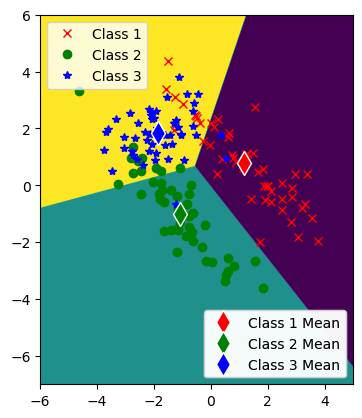

In [51]:
#Plot the final decision boundary and regions for the 3-class problem (dataset4)
plotFinalDecisionBoundary(dataset4_train, classes_4, mean_vectors_first_dataset_4)

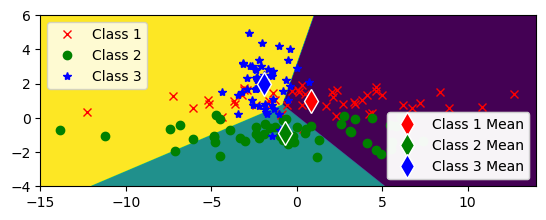

In [52]:
#Plot the final decision boundary and regions for the 3-class problem (dataset5)
plotFinalDecisionBoundary(dataset5_train, classes_5, mean_vectors_first_dataset_5)

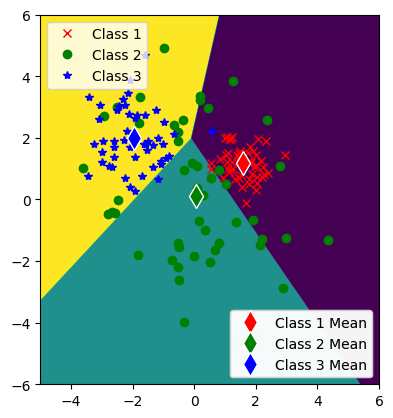

In [53]:
#Plot the final decision boundary and regions for the 3-class problem (dataset6)
plotFinalDecisionBoundary(dataset6_train, classes_6, mean_vectors_first_dataset_6)

In [99]:
# leaving points in indeterminate regions as unclassified
def calculate_metrics_for_dataset(dataset, mean_vectors, classes):
    correct_predictions = 0
    total_predictions = 0
    unclassified_points = 0

    for sample in dataset:
        x, true_class = sample[:-1], int(sample[-1])
        distances = [np.linalg.norm(x - mean_vectors[class_label - 1]) for class_label in classes]
        predicted_class = np.argmin(distances) + 1

        if predicted_class == true_class:
            correct_predictions += 1
        elif all(value == 0 for value in distances):
            unclassified_points += 1

        total_predictions += 1

    accuracy = correct_predictions / total_predictions
    error = 1 - accuracy
    unclassified_rate = unclassified_points / total_predictions

    return accuracy, error, unclassified_rate

def calculate_metrics(training_set, test_set, mean_vectors, classes):
    train_accuracy, train_error, train_unclassified = calculate_metrics_for_dataset(training_set, mean_vectors, classes)
    test_accuracy, test_error, test_unclassified = calculate_metrics_for_dataset(test_set, mean_vectors, classes)

    return train_accuracy, train_error, train_unclassified, test_accuracy, test_error, test_unclassified

dataset4_test = np.array(dataset4_test)
dataset5_test = np.array(dataset5_test)
dataset6_test = np.array(dataset6_test)

mean_vectors_first_dataset_4 = mean_arr_convert[0][1]
mean_vectors_first_dataset_5 = mean_arr_convert[1][1]
mean_vectors_first_dataset_6 = mean_arr_convert[2][1]

classes_of_4 = [1, 2, 3]
classes_of_5 = [1, 2, 3]
classes_of_6 = [1, 2, 3]

dataset4_train_output = calculate_metrics(dataset4_train, dataset4_test, mean_vectors_first_dataset_4, classes_of_4)
dataset5_train_metrics = calculate_metrics(dataset5_train, dataset5_test, mean_vectors_first_dataset_5, classes_of_5)
dataset6_train_metrics = calculate_metrics(dataset6_train, dataset6_test, mean_vectors_first_dataset_6, classes_of_6)

data = {
    'accuracy': [dataset4_train_output[0], dataset4_train_output[3],
                 dataset5_train_output[0], dataset5_train_output[3],
                 dataset6_train_output[0], dataset6_train_output[3]],
    'error': [dataset4_train_output[1], dataset4_train_output[4],
              dataset5_train_output[1], dataset5_train_output[4],
              dataset6_train_output[1], dataset6_train_output[4]],
    'unclassified': [dataset4_train_output[2], dataset4_train_output[5],
                     dataset5_train_output[2], dataset5_train_output[5],
                     dataset6_train_output[2], dataset6_train_output[5]]
}

index = ['dataset_4 train', 'dataset_4 test', 'dataset_5 train', 'dataset_5 test', 'dataset_6 train', 'dataset_6 test']

df = pd.DataFrame(data, index=index)
print(df)

                 accuracy     error  unclassified
dataset_4 train  0.833333  0.166667           0.0
dataset_4 test   0.866667  0.133333           0.0
dataset_5 train  0.646667  0.353333           0.0
dataset_5 test   0.780000  0.220000           0.0
dataset_6 train  0.806667  0.193333           0.0
dataset_6 test   0.760000  0.240000           0.0


In [138]:
#2c:classify all points in feature space

for i, train_dataset in enumerate(train_datasets):
    classes, mean_vectors_array = mean_arr_convert[i]
    test_predicted_labels = []
    for _, row in test_dataset.iterrows():
        x = row[['X-axis', 'Y-axis']].values

        distances = np.linalg.norm(mean_vectors_array - x, axis=1)
        predicted_class = classes[np.argmin(distances)]
        test_predicted_labels.append(predicted_class)
    predicted_labels.append(test_predicted_labels)


Predicted Labels:
[3.0, 1.0, 3.0, 1.0, 3.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 3.0, 1.0, 3.0, 3.0, 1.0, 1.0, 3.0, 1.0, 3.0, 2.0, 1.0, 3.0, 2.0, 1.0, 1.0, 3.0, 3.0, 1.0, 1.0, 1.0, 3.0, 3.0, 1.0, 3.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 1.0, 3.0, 2.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 3.0, 1.0, 1.0, 3.0, 3.0, 3.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 3.0, 3.0, 3.0, 1.0, 2.0, 1.0, 1.0, 3.0, 1.0, 3.0, 2.0, 1.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 1.0, 2.0, 2.0, 3.0, 1.0, 1.0, 1.0, 3.0, 1.0, 3.0, 3.0, 3.0, 3.0, 1.0, 1.0, 1.0, 3.0, 2.0, 1.0, 3.0, 3.0, 3.0, 1.0, 2.0, 3.0, 1.0, 1.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0, 3.0, 3.0, 1.0, 3.0, 3.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 3.0, 3.0, 3.0, 3.0, 1.0, 3.0, 3.0, 1.0, 3.0, 1.0, 2.0, 1.0, 1.0, 3.0]
[3.0, 1.0, 3.0, 1.0, 3.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 3.0, 1.0, 3.0, 3.0, 1.0, 1.0, 3.0, 1.0, 3.0, 2.0, 1.0, 3.0, 2.0, 1.0, 1.0, 3.0, 3.0, 1.0, 1.0, 1.0, 3.0, 3.0, 1.0, 3.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 1.0, 3.0, 2.0, 1.0, 